## Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import gc
import joblib

## Read data files

In [2]:
calendar = pd.read_csv("C:/Users/yukti/MSBAIM MOD 3/Machine Learning/m5-forecasting-accuracy/calendar.csv")
prices = pd.read_csv("C:/Users/yukti/MSBAIM MOD 3/Machine Learning/m5-forecasting-accuracy/sell_prices.csv")
sales = pd.read_csv("C:/Users/yukti/MSBAIM MOD 3/Machine Learning/m5-forecasting-accuracy/sales_train_evaluation.csv")

## Data Preprocessing

In [3]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [4]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [5]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [6]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [7]:
df.shape

(60034810, 22)

## Exploratory Data Analysis

C:\Users\yukti\AppData\Local\Temp\ipykernel_55556\2181428352.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=grouped_data, x='state_id', y='sold', hue='cat_id', palette=colors, ci=None)


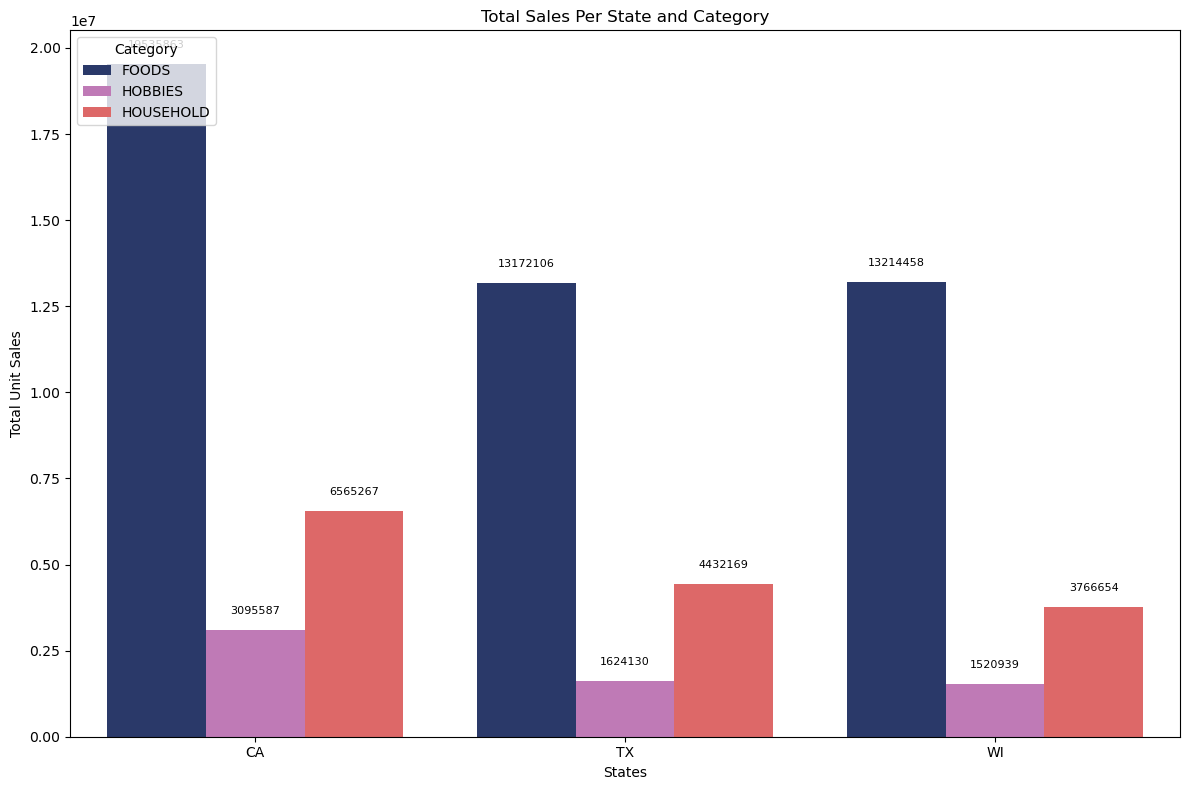

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors
colors = ["#1f3374", "#cb6ebe", "#f05555"]

# Assuming 'df' is your DataFrame containing the relevant columns: 'state_id', 'cat_id', and 'sold'

# Group by 'state_id' and 'cat_id', then sum 'sold'
grouped_data = df.groupby(['state_id', 'cat_id'])['sold'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Using Seaborn's barplot function
ax = sns.barplot(data=grouped_data, x='state_id', y='sold', hue='cat_id', palette=colors, ci=None)

# Adding labels on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 10), 
                   textcoords = 'offset points', fontsize=8)

# Adding ticks and labels
plt.xlabel('States')
plt.ylabel('Total Unit Sales')
plt.title('Total Sales Per State and Category')
plt.legend(title='Category', loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\yukti\AppData\Local\Temp\ipykernel_55556\234266195.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=grouped_data, x='dept_id', y='sell_price', hue='state_id', palette=colors, ci=None)


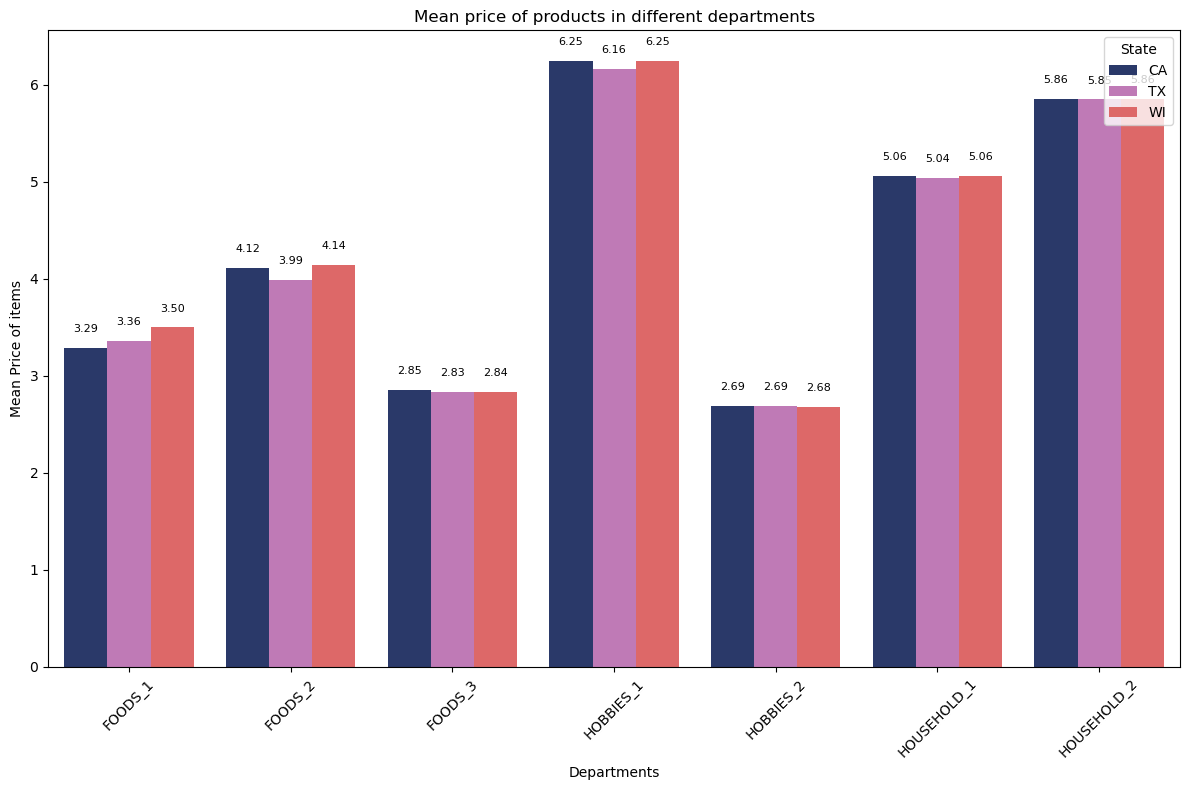

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors
colors = ["#1f3374", "#cb6ebe", "#f05555"]

# Assuming 'df' is your DataFrame containing the relevant columns: 'dept_id', 'sell_price', and 'state_id'

# Group by 'dept_id' and 'state_id', then calculate the mean 'sell_price'
grouped_data = df.groupby(['dept_id', 'state_id'])['sell_price'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Using Seaborn's barplot function with custom colors
ax = sns.barplot(data=grouped_data, x='dept_id', y='sell_price', hue='state_id', palette=colors, ci=None)

# Adding labels on top of each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                xytext=(0, 10), 
                textcoords='offset points', fontsize=8)

# Adding ticks and labels
plt.xlabel('Departments')
plt.ylabel('Mean Price of items')
plt.title('Mean price of products in different departments')
plt.legend(title='State', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


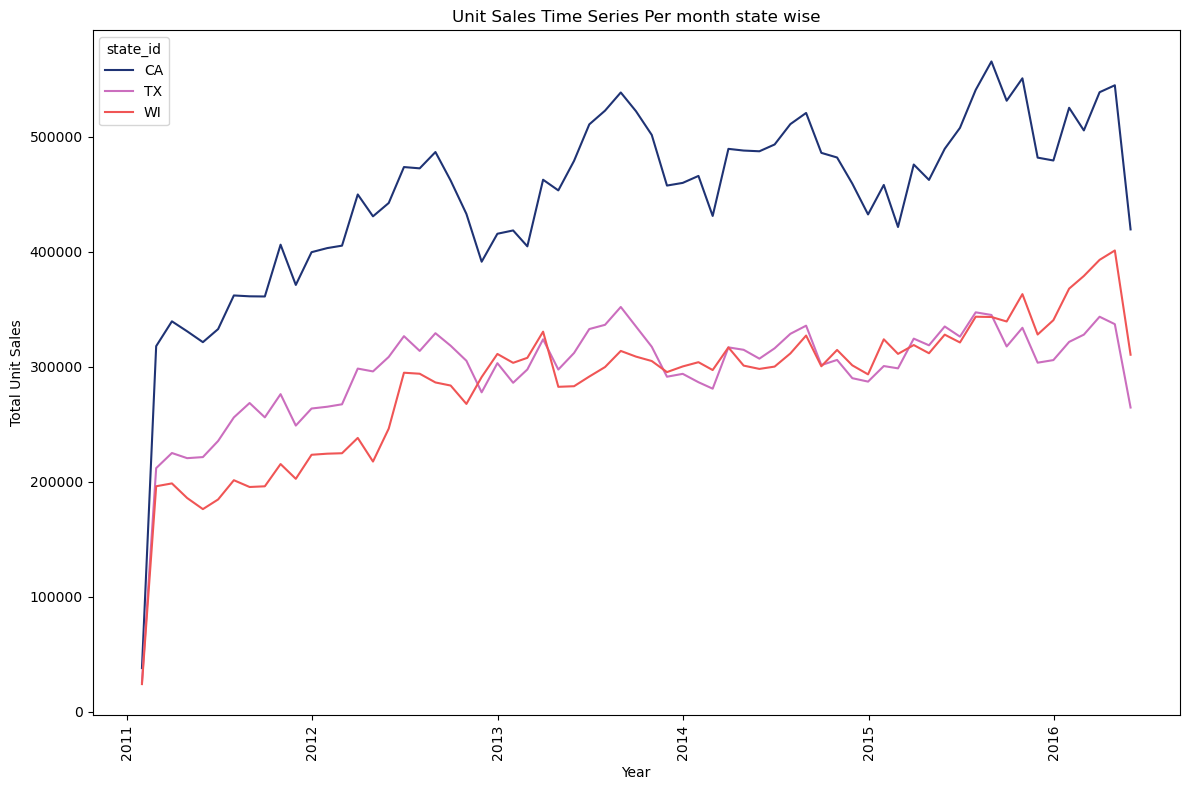

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthBegin

# Define custom colors
colors = ["#1f3374", "#cb6ebe", "#f05555"]

# Assuming 'df' is your DataFrame containing the relevant columns: 'state_id', 'date', and 'sold'

# Convert 'date' column to datetime if it's not already in datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by 'month' and 'state_id', then calculate the sum of 'sold'
grouped_data = df.groupby([pd.Grouper(key='date', freq='M'), 'state_id'])['sold'].sum().reset_index()

# Remove rows where 'sales' is 0
grouped_data = grouped_data[grouped_data['sold'] != 0]

# Plotting
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Using Seaborn's lineplot function with custom colors
sns.lineplot(data=grouped_data, x='date', y='sold', hue='state_id', palette=colors)

# Adding ticks and labels
plt.xlabel('Year')
plt.ylabel('Total Unit Sales')
plt.title('Unit Sales Time Series Per month state wise')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


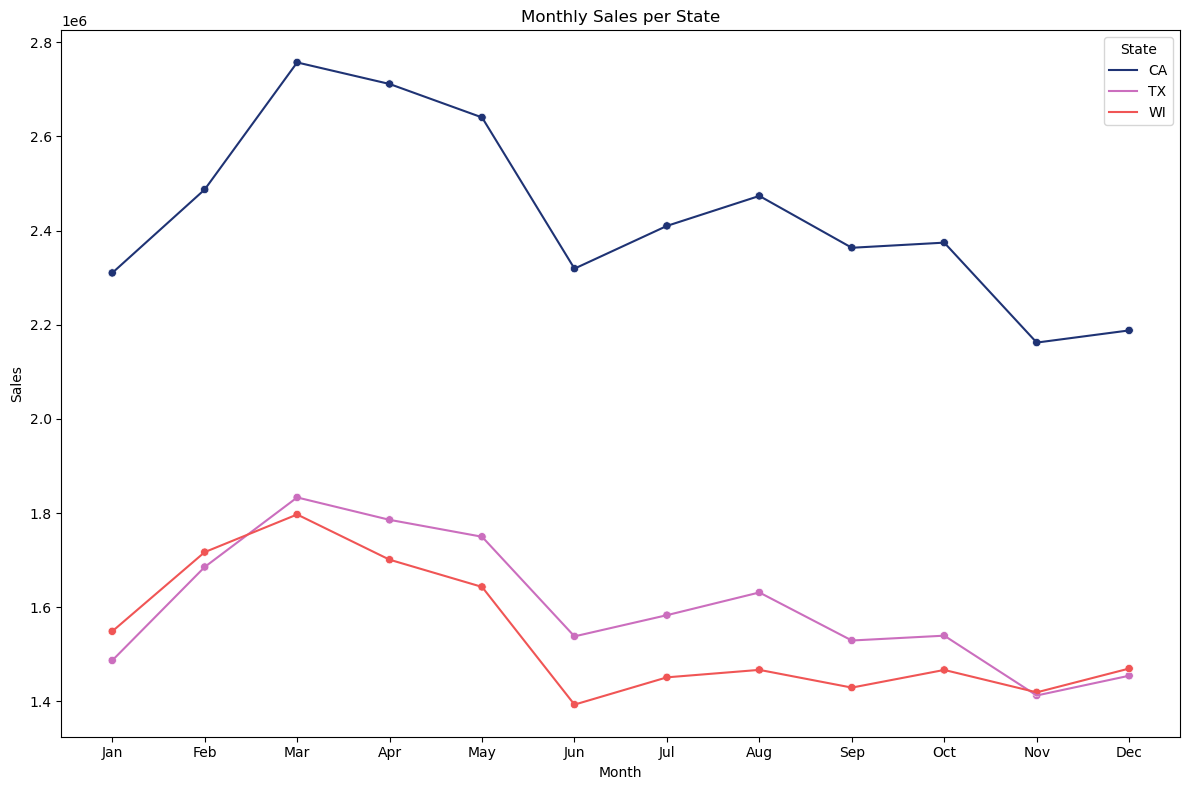

In [40]:

# Convert 'date' column to datetime if it's not already in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract month from the 'date' column
df['month'] = df['date'].dt.month

# Group by 'month' and 'state_id', then calculate the sum of 'sold'
grouped_data = df.groupby(['month', 'state_id'])['sold'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Using Seaborn's lineplot function with custom colors
sns.lineplot(data=grouped_data, x='month', y='sold', hue='state_id', palette=colors)

# Adding points to the line plot
sns.scatterplot(data=grouped_data, x='month', y='sold', hue='state_id', palette=colors, legend=False)

# Adding ticks and labels
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales per State')
plt.legend(title='State', loc='upper right')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

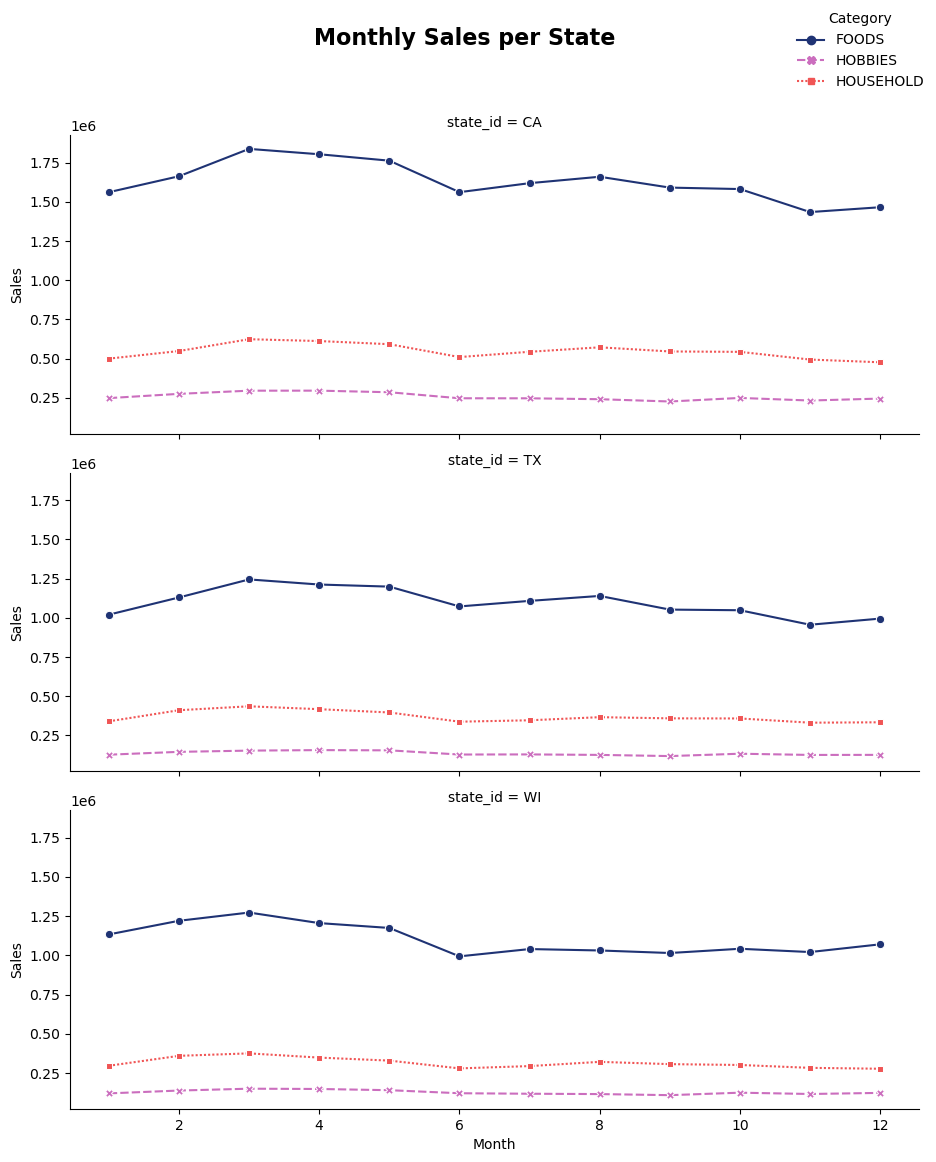

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors
colors = ["#1f3374", "#cb6ebe", "#f05555"]

# Group by 'month', 'state_id', and 'cat_id', then calculate the sum of 'sold'
grouped_data = df.groupby(['month', 'state_id', 'cat_id'])['sold'].sum().reset_index()

# Plotting
g = sns.FacetGrid(grouped_data, col='state_id', col_wrap=1, height=4, aspect=2)
g.map_dataframe(sns.lineplot, x='month', y='sold', hue='cat_id', style='cat_id', markers=True, palette=colors)
g.set_axis_labels('Month', 'Sales')
g.fig.suptitle('Monthly Sales per State', fontsize=16, fontweight='bold')
g.add_legend(title='Category', loc='upper right')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
plt.show()


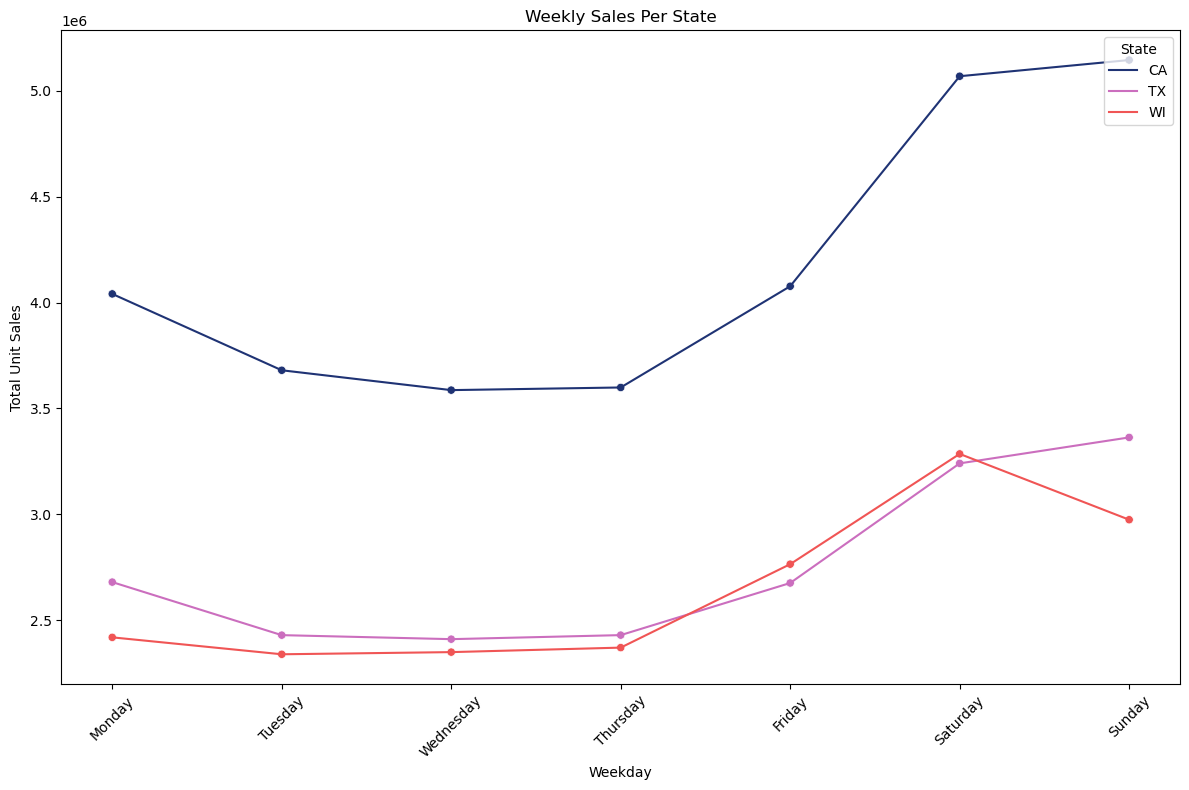

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors
colors = ["#1f3374", "#cb6ebe", "#f05555"]
weekday_categories = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_categories, ordered=True)

# Group by 'weekday' and 'state_id', then calculate the sum of 'sold'
grouped_data = df.groupby(['weekday', 'state_id'])['sold'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Using Seaborn's lineplot function with custom colors
sns.lineplot(data=grouped_data, x='weekday', y='sold', hue='state_id', palette=colors)

# Adding points to the line plot
sns.scatterplot(data=grouped_data, x='weekday', y='sold', hue='state_id', palette=colors, legend=False)

# Adding ticks and labels
plt.xlabel('Weekday')
plt.ylabel('Total Unit Sales')
plt.title('Weekly Sales Per State')
plt.legend(title='State', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()